In [44]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [45]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [46]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.5105, -0.2776,  0.8986, -0.0500,  0.1710, -0.3945, -0.1057, -0.0334],
        [-0.5105, -0.2776,  0.8986, -0.0500,  0.1710, -0.3945, -0.1057, -0.0334],
        [-0.5105, -0.2776,  0.8986, -0.0500,  0.1710, -0.3945, -0.1057, -0.0334]],
       grad_fn=<SelectBackward0>)

In [47]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [48]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [49]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [50]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        """
        key_size: 指定输入到 Multi-Head-Attention 的 input 向量 经过一个 key_size 个数的线性层变为 key 向量
        query_size: 同理
        value_size: 同理
        """
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [51]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [52]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        """
        key_size: 指定输入到 Multi-Head-Attention 的 input 向量 经过一个 key_size 个数的线性层变为 key 向量
        query_size: 同理
        value_size: 同理
        """

        self.num_hiddens = num_hiddens
        # vocab_size 是在 embedding 层中进行 one-hot 编码步骤用到的
        # num_hiddens 是把输入到 embedding 的最后一个维度的每个元素展开成 num_hiddens 长的向量
        # num_hiddens 代表每个词元 使用 num_hiddens 长度的向量表示
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 对输入的数据添加位置编码
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights

        # X 是经过 Encoder 汇聚之后的结果
        # X 包含了所有的输入信息，但又不是全都包含在了一个像是 RNN 的 state 矩阵中
        # 把 X 丢给 Encoder 的第二个注意力层后，由这个注意力层来选择使用哪些信息
        return X

In [53]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [54]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i  # 存一下自己是第几个块
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)  # norm 应该等于 num_hiddens 吧
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,  # ffn_num_input 应该等于 num_hiddens 把
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)  # norm_shape 应该等于 num_hiddens 吧

    def forward(self, X, state):
        # X (batch_size, num_steps, embedding_size=num_hiddens)
        # decoder_block 拿到的输入 X 是原始样本经过 embedding 后的产物
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示

        # 以下这段注释可能有点毛病，注意分别是第i号个 Decoder-Block 还是第i个 Decoder-Block

        # state[2] 中的 [self.i] 并不是代表第 i 个时刻的东西
        # 而是 第i号个 Decoder 块的输入数据
        # 在第 0 号时间步的数据进行前向运算的时候 state[2][...] 所有位置都是 None
        # 因此在计算第 0 号时间步前向运算时，是第一次在 state[2][...] 中填充内容(对于每个样本序列而言，仅填充了一行)
        # 接着计算后边的时间步的数值进行前向运算的时候 只需要把当前层的输入往下进行拼接即可

        # state[2] 对于训练的过程没有什么帮助
        # 在预测的时候才有帮助，因为预测的时候，每个时间步产生的每一个 Decoder-Block 的输出是一个时间步一个时间步产生的
        # 而每次让 q 和所有的 k 做运算的时候，是需要把之前上一层的 Decoder-Block 产生的内容作为下一层 Decoder-Block 中
        # 的 Attention 机制的 key-values pairs 的输入的，所以需要把之前时间步产生的 key-value 对给保存下来
        
        # 这同时也解释了，为什么在预测的时候不需要 valid_lens, 因为在 state[2] 中保存的 key_value 也就只有那么点
        # 也就只有目前能够看到的序列产生的输出作为 key_value pairs 而后边的 key_value pairs 根本没存进去呢
        
        # 另外也能够解释为什么在训练的时候需要使用 valid_lens，因为在训练的时候一次性的，所有时间步的值都可以并行的作为输入
        # 而 Self-Attention 计算第 i 个 q 的输出并不需要非得把前边的那些 q 都计算完了才能计算第 i 个 q
        # 仅需要有所有的 key_values pairs 就可以计算任意一个 q 产生的输出了，这个不像 RNN 只能串行计算，而是可以并行计算
        # 因此，一次性就输入进模型所有的 key_values pairs 了，这时候计算第 i 个 q 的时候与每一个 k 都进行了 dot product
        # 但是，按照预测的逻辑来看，计算第 i 个 q 的 dot product 的时候，i 到 num_steps 的这些 q 产生的输出还不存在呢
        # 但是在训练的时候这些 q 却可以被看到，因此就需要 valid_lens 来指明当前的 q 只能看到前多少个 key_values pairs

        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:  # 应该是 net.train() 起的作用；把 self.training 设置为 True
            batch_size, num_steps, _ = X.shape  # _ 是 embedding_size
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            # dec_valid_lens 是一个矩阵
            # 做注意力机制的时候，每一个序列中的第 i 个 q 只能和这个序列的前 i 个 k 进行得分计算
            # 因此就是 [1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        # 做注意力机制的时候，每一个序列中的第 i 个 q 只能和这个序列的前 i 个 k 进行得分计算
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [55]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [56]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):  # i 代表的是第 i 号块，而 state[2][i] 确实是第 i 个块的输入，且是第 i-1 号块的输出
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [57]:
import os


def read_data_nmt():
    """Load the English-French dataset.

    Defined in :numref:`sec_machine_translation`"""
    data_dir = '/Users/blueberry/git-Library/Dive-into-Deep-Learning/10-Attention-Mechanisms-and-Transformers/data/'
    with open(os.path.join(data_dir, 'seq.data'), 'r') as f:
        return f.read()


def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset.

    Defined in :numref:`subsec_mt_data_loading`"""
    text = d2l.preprocess_nmt(read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = d2l.build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = d2l.build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

#### 训练

In [58]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 3, 0.1, 64, 10
lr, num_epochs, device = 0.005, 60, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]  # 对最后一个维度且长度为 32 的向量做 LayerNorm 操作

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps, num_examples=600)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

In [59]:
src_vocab.idx_to_token[114]

'认识'

loss 0.051, 8995.8 tokens/sec on cpu


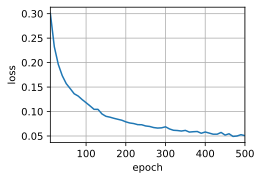

In [80]:
# 编码器的输入是一个二维的样本矩阵 X 每一行都是一个句子
# 解码器的输入 dec_input 也是一个样本矩阵，每一行都是一个句子并且有开始标志 <bos> 是在训练的时候添加上的
d2l.train_seq2seq(net, train_iter, 0.005, 500, tgt_vocab, device)

In [61]:
torch.save(net, './models/transformer.pkl')

#### 计算 BLEU

In [82]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence.

    Defined in :numref:`sec_seq2seq_training`"""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [93]:
engs = ['呵呵', "有 什么 好 听的歌", '我 不 喜欢 你 了', '许兵 是 谁', '你 有 朋友 吗']
# fras = ['是 王若 猫 的', '今夜 的 你 应该 明 了', '你 敢 我 就 敢 小样 敢 跟 我 叫板']
for eng in engs:
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}')
    # print(f'{eng} => {translation}, ',
    #       f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

呵呵 => <unk> 你 又 生气 了 吗
有 什么 好 听的歌 => 我 没有 <unk>
我 不 喜欢 你 了 => 我 本来 就 不 喜欢 你
许兵 是 谁 => 是 我 善良 可爱 的 主人 的 老公 啊
你 有 朋友 吗 => 不知 啊


In [77]:
# enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
#     -1, num_steps))
# enc_attention_weights.shape

In [64]:
# d2l.show_heatmaps(
#     enc_attention_weights.cpu(), xlabel='Key positions',
#     ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
#     figsize=(7, 3.5))